# Car Sales Project 

Rusty Bargain used car sales service is developing an app to attract new customers. In that app, you can quickly find out the market value of your car. You have access to historical data: technical specifications, trim versions, and prices. You need to build the model to determine the value. 

Rusty Bargain is interested in:

- the quality of the prediction;
- the speed of the prediction;
- the time required for training

In [1]:
#import's
import pandas as pd
import numpy as np

from time import time
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error


from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

from catboost import Pool, CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Data preparation

In [2]:
#Downloading the data
data = pd.read_csv('/datasets/car_data.csv')

In [3]:
#Preliminary examination
def pre_exam(df):
    print('head:')
    display(df.head(3))
    print('info:')
    display(df.info())
    print('describe:')
    display(df.describe())
    print('duplicate: ',df.duplicated().sum())
    print('isna:')
    display(df.isna().sum())
    print('total missing: {:.2%}'.format((df.isna().sum().sum())/len(df)))

In [4]:
pre_exam(data)

head:


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47


info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Mileage              354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


None

describe:


,Price,RegistrationYear,Power,Mileage,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


duplicate:  262
isna:


DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Mileage                  0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

total missing: 51.10%


I have unnecessary columns: drop_columns = [NumberOfPictures, PostalCode, DateCrawled, DateCreated, LastSeen]
I am trying to predict the price,the PostalCode column for example, will only interferes and not contribute to the prediction,
therefore it will be better to simply take them off.

These are a lot of missing values in columns: missing - [VehicleType, Gearbox, Model, FuelType, NotRepaired]
i will try to fill them up because the method of deleting them will leave me without a data

date_columns = [DateCrawled, DateCreated, LastSeen]
I have three columns in a date format that is problematic, I do not see how to create a new feature that will be useful, so I will delete them

Category columns I will need to encode: categorical_columns = [VehicleType, Gearbox, Model, FuelType, Brand, NotRepaired]

Numeric columns should be scailed: numrical_columns = [Price, RegistrationYear, Power, Mileage, RegistrationMonth, NumberOfPictures, PostalCode]

I have 262 duplicate, I will simply drop them.

outliers - I have zeros in the price column and registration year cant be 1000 or 9999.



**Pre Pro**

In [5]:
#copy of data for pre processing
data_prepro = data.copy()

In [6]:
#lower case
data_prepro.columns = data.columns.str.lower()
data_prepro.columns

Index(['datecrawled', 'price', 'vehicletype', 'registrationyear', 'gearbox',
       'power', 'model', 'mileage', 'registrationmonth', 'fueltype', 'brand',
       'notrepaired', 'datecreated', 'numberofpictures', 'postalcode',
       'lastseen'],
      dtype='object')

In [7]:
drop_columns = data_prepro[['numberofpictures','postalcode','datecrawled','datecreated','lastseen']]

missing_columns = ['vehicletype','gearbox','model','fueltype','notrepaired']

date_columns = ['datecrawled','datecreated','lastseen']

categorical_columns = ['vehicletype','gearbox','model','fueltype','brand','notrepaired']

numrical_columns = ['price','registrationyear','power','mileage','registrationmonth','numberofpictures','postalcode']


In [8]:
#droping duplicated 
data_prepro = data_prepro.drop_duplicates()

In [9]:
#droping unecessary columns
data_prepro = data_prepro.drop(drop_columns,axis=1)

**missing processing**

In [10]:
data_prepro[missing_columns].head(3)

,vehicletype,gearbox,model,fueltype,notrepaired
0,NaN,manual,golf,petrol,NaN
1,coupe,manual,NaN,gasoline,yes
2,suv,auto,grand,gasoline,NaN


In [11]:
for i in missing_columns:
    print('column: ',i)
    print('percent of missing: {:.2}'.format(data_prepro[i].isna().sum()/len(data_prepro[i])))
    print('values: \n',data_prepro[i].value_counts(),'\n')

column:  vehicletype
percent of missing: 0.11
values: 
 sedan          91399
small          79753
wagon          65115
bus            28752
convertible    20180
coupe          16147
suv            11991
other           3286
Name: vehicletype, dtype: int64 

column:  gearbox
percent of missing: 0.056
values: 
 manual    268034
auto       66243
Name: gearbox, dtype: int64 

column:  model
percent of missing: 0.056
values: 
 golf                  29215
other                 24402
3er                   19744
polo                  13057
corsa                 12559
                      ...  
i3                        8
rangerover                4
serie_3                   4
range_rover_evoque        2
serie_1                   2
Name: model, Length: 250, dtype: int64 

column:  fueltype
percent of missing: 0.093
values: 
 petrol      216161
gasoline     98658
lpg           5307
cng            565
hybrid         233
other          204
electric        90
Name: fueltype, dtype: int64 

column:

In [12]:
data_prepro['notrepaired'] = data_prepro['notrepaired'].fillna('no')
data_prepro['gearbox'] = data_prepro['gearbox'].fillna('manual')
data_prepro['model'] = data_prepro['model'].fillna('missing')
data_prepro['vehicletype'] = data_prepro['vehicletype'].fillna('missing')
data_prepro['fueltype'] = data_prepro['fueltype'].fillna('missing')

NotRepaired column - The natural state is 'no', and indeed we see that 246,927 is 'no' and only 36,035 is 'yes', so I assume if he did not state anything it is 'no'.

Gearbox column - I filled according to the same principle as the NotRepaired column
The majority is 'manual' and only 'auto' so I assume the missing are 'manual'

Model column - is more problematic, there are too many different values and it's correspond with the Brand column, there are only five percent missing but I do not want to deleting them, I will fill them with 'missing' maybe they will have a contribution

vehicletype and fueltype columns like model column


In [13]:
#fill check
data_prepro.isna().sum()

price                0
vehicletype          0
registrationyear     0
gearbox              0
power                0
model                0
mileage              0
registrationmonth    0
fueltype             0
brand                0
notrepaired          0
dtype: int64

**encoder**

In [14]:
encoder = OrdinalEncoder()
data_prepro[categorical_columns] = encoder.fit_transform(data_prepro[categorical_columns])
data_prepro.head(3)

,price,vehicletype,registrationyear,gearbox,power,model,mileage,registrationmonth,fueltype,brand,notrepaired
0,480,3.0,1993,1.0,0,116.0,150000,0,7.0,38.0,0.0
1,18300,2.0,2011,1.0,190,153.0,125000,5,2.0,1.0,1.0
2,9800,7.0,2004,0.0,163,117.0,125000,8,2.0,14.0,0.0


**outliers**

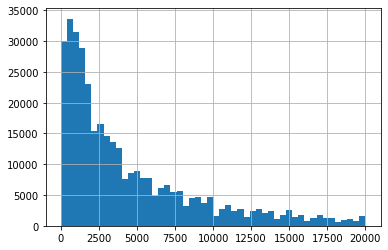

In [15]:
#target disterbution
data_prepro['price'].hist(bins=50);

In [16]:
print(data_prepro.loc[(data_prepro['price'] < 100), 'price'].count())
data_prepro = data_prepro.drop(data_prepro.loc[(data_prepro['price'] < 100), 'price'].index)
print(data_prepro.loc[(data_prepro['price'] < 100), 'price'].count())

13311
0


I do not know any car that sells for under $ 100 and if there is one I do not want to mess with, it is an outlier

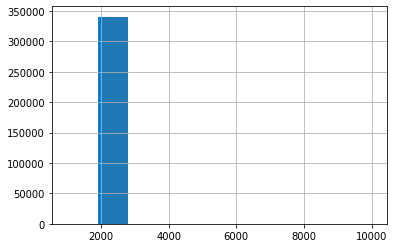

In [17]:
data_prepro['registrationyear'].hist();

In [18]:
print(data_prepro.loc[(data_prepro['registrationyear'] < 1900) | (data_prepro['registrationyear'] > 2021), 'registrationyear'].count())
data_prepro = data_prepro.drop(data_prepro.loc[(data_prepro['registrationyear'] < 1900) | (data_prepro['registrationyear'] > 2021), 'registrationyear'].index)
print(data_prepro.loc[(data_prepro['registrationyear'] < 1900) | (data_prepro['registrationyear'] > 2021), 'registrationyear'].count())


115
0


In 1903 Ford released their first Model A car (which looked like a carriage), everything below 1900 is an outlier.
also power it goes up to 20000, but the most powerful cars in existence only have about 1500 hp.

**corr**

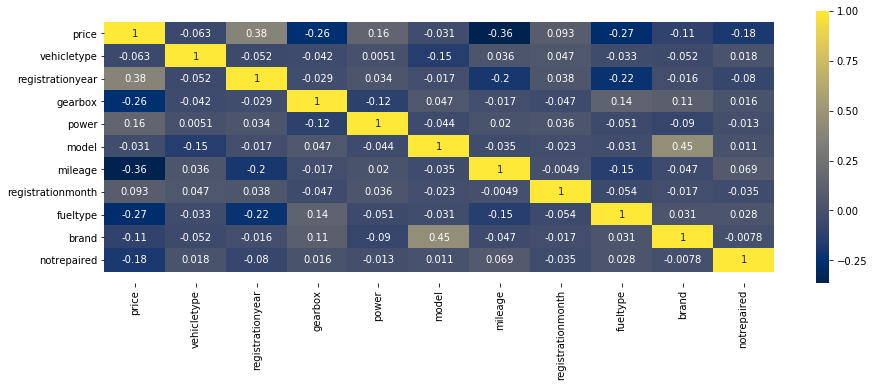

In [19]:
plt.figure(figsize=(15,5))
ax = sns.heatmap(data_prepro.corr(), annot=True, cmap='cividis')

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5);
plt.yticks(rotation=0);

As I mentioned earlier we see a strong correlation between model and brand (0.45), this is not good because the correlation between price and brand is only -0.11, and the correlation between the model and the price is -0.031, it could be that if we remove the car model column the quality of the algorithm will improve.

registrationyear, gearbox, power, mileage, fueltype correlation with price is good, not really high but contributes more than interferes.
Attention should be paid to the categorical features Pearson Correlation will not correctly reflect their correlation with the target.

**split**

In [20]:
target = data_prepro['price']
features = data_prepro.drop(['price'], axis=1)
features_train, features_test, target_train, target_test = train_test_split(features,target,test_size=0.3,random_state=12345)

**scaling**

In [21]:
scaler = StandardScaler()
features_train = scaler.fit_transform(features_train)
features_test = scaler.transform(features_test)

**Defining functions**

I built two functions to help me with the tuning of the parameters and measuring the time

In [22]:
def GridSearch(model,params):
    start=time()
    name = GridSearchCV(model, params,'r2',cv=5).fit(features_train, target_train)
    end = time()-start
    print('Model: ',name.best_estimator_)
    print('The best hyperparameters are: ',name.best_params_)
    print('R2 score: {:.3}'.format(name.best_score_))
    print('Tuning time: ',np.round(end, 3),'s')

In [23]:
def TrainPredictTime(best_model):
    start = time()
    model = best_model.fit(features_train,target_train)
    traning_time = time() - start
    predi = model.predict(features_test)
    predi_time = (time() - start) - traning_time
    RMSE = mean_squared_error(target_test, predi) **0.5
    print('test traning time: {}'.format(traning_time),'s')
    print('test prediction time: {}'.format(predi_time),'s')
    print('test RMSE score: {}'.format(RMSE))

## Model training

**Tuning Hyper Parameters**

In [24]:
#DecisionTree
params_DT = {
    'splitter': ['best','random'],
    'max_depth' : [1,50,70],
    'min_samples_leaf' : [1,10,20],
    'min_weight_fraction_leaf' : [0,0.5],
    'max_features' : ['auto','log2','sqrt',None],
    'max_leaf_nodes' : [None,30,60,90]
    }

GridSearch(DecisionTreeRegressor(),params_DT)

Model:  DecisionTreeRegressor(criterion='mse', max_depth=50, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=10,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')
The best hyperparameters are:  {'max_depth': 50, 'min_samples_leaf': 10}
R2 score: 0.829
Tuning time:  22.171 s


I start with a decision tree that did a pretty good job with R2 score of 0.82 in 22 seconds
this is the time it took to adjust parameters and cros valideit 5 times 

In [25]:
#RandomForest
params_RF = {
    'max_depth':[None,10,50],
    'min_samples_leaf':[5,10,15],
    'n_estimators':[300,500,700],
    }


GridSearch(RandomForestRegressor(),params_RF)

Model:  RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=50,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
The best hyperparameters are:  {'max_depth': 50}
R2 score: 0.852
Tuning time:  75.83 s


Random Forest slightly improved the R2 score to 0.85 but took more time 91s times four

In [26]:
#LinearRegression
params_LR = {}

GridSearch(LinearRegression(),params_LR)

Model:  LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
The best hyperparameters are:  {}
R2 score: 0.386
Tuning time:  1.134 s


Linear Regression I did not adjust any parameter, that's why it was really fast only one second but its R2 score is poor, probably it is impossible to match a straight line to the data

In [27]:
#CatBoostRegressor 
params_CAT = {
     'depth':[None,4,6],
     'learning_rate':[0.01, 0.05, 0.1],
     'iterations':[50, 100,150]
    }


GridSearch(CatBoostRegressor(),params_CAT)

0:	learn: 4475.2427611	total: 82.5ms	remaining: 1m 22s
1:	learn: 4446.7005940	total: 181ms	remaining: 1m 30s
2:	learn: 4418.9583758	total: 197ms	remaining: 1m 5s
3:	learn: 4391.1671712	total: 291ms	remaining: 1m 12s
4:	learn: 4363.2255472	total: 387ms	remaining: 1m 16s
5:	learn: 4336.8479050	total: 485ms	remaining: 1m 20s
6:	learn: 4310.9092856	total: 583ms	remaining: 1m 22s
7:	learn: 4284.5671375	total: 681ms	remaining: 1m 24s
8:	learn: 4258.8788542	total: 779ms	remaining: 1m 25s
9:	learn: 4233.4053758	total: 876ms	remaining: 1m 26s
10:	learn: 4208.1073311	total: 886ms	remaining: 1m 19s
11:	learn: 4183.6981170	total: 986ms	remaining: 1m 21s
12:	learn: 4159.2483805	total: 1.08s	remaining: 1m 22s
13:	learn: 4135.8032284	total: 1.18s	remaining: 1m 23s
14:	learn: 4111.6241007	total: 1.28s	remaining: 1m 24s
15:	learn: 4087.0611444	total: 1.38s	remaining: 1m 24s
16:	learn: 4064.1420869	total: 1.48s	remaining: 1m 25s
17:	learn: 4041.3621783	total: 1.58s	remaining: 1m 26s
18:	learn: 4018.5962

cat boost took forever, I do not know if it's because my computer is old or it's just what cat boost takes, but it took to adjust its parameters 1555 seconds which is 25 minutes, but its R2 scores is the best so far 0.86 difference of 0.01 from RandomForest i not sure that justifies the long time.

In [28]:
#LightGBM 
params_LGBM = {
     'num_leaves':[100,150,200],
     'max_depth':[10,30,50]
    }


GridSearch(LGBMRegressor(),params_LGBM)

Model:  LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=200, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
The best hyperparameters are:  {'num_leaves': 200}
R2 score: 0.87
Tuning time:  171.083 s


LightGBM took a tenth of the time and reached a slightly higher result

In [29]:
#XGBoost
params_XGBR = {
     'n_estimators':[100,200,300],
     'max_depth':[5,10,15]
    }


GridSearch(XGBRegressor(),params_XGBR)

[15:45:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:45:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:46:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:46:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:46:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:46:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:47:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:47:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

XGBoost took three times as long as LightGBM but achieved the highest result 0.871, again a difference of 0.002 is not necessarily justifies the long time tuning

**Test set time and RMSE score**

In [30]:
#DecisionTree
TrainPredictTime(DecisionTreeRegressor(max_depth=50,min_samples_leaf=10))

test traning time: 0.7847771644592285 s
test prediction time: 0.02371978759765625 s
test RMSE score: 1859.9569484896763


In [31]:
#RandomForest
TrainPredictTime(RandomForestRegressor(max_depth=None))

test traning time: 6.74365496635437 s
test prediction time: 0.45813488960266113 s
test RMSE score: 1719.0372349766758


In [32]:
#LinearRegression
TrainPredictTime(LinearRegression())

test traning time: 0.06842803955078125 s
test prediction time: 0.0019795894622802734 s
test RMSE score: 3569.3805174157997


In [33]:
#CatBoostRegressor 
TrainPredictTime(CatBoostRegressor(learning_rate= 0.1))

0:	learn: 4224.4086190	total: 66.9ms	remaining: 1m 6s
1:	learn: 3978.8667375	total: 167ms	remaining: 1m 23s
2:	learn: 3755.9084161	total: 267ms	remaining: 1m 28s
3:	learn: 3558.0446446	total: 369ms	remaining: 1m 31s
4:	learn: 3395.3165683	total: 471ms	remaining: 1m 33s
5:	learn: 3244.3410191	total: 571ms	remaining: 1m 34s
6:	learn: 3118.1515721	total: 670ms	remaining: 1m 35s
7:	learn: 3005.2706037	total: 779ms	remaining: 1m 36s
8:	learn: 2900.0400301	total: 961ms	remaining: 1m 45s
9:	learn: 2810.6495857	total: 1.06s	remaining: 1m 45s
10:	learn: 2729.1663451	total: 1.16s	remaining: 1m 44s
11:	learn: 2657.1447576	total: 1.26s	remaining: 1m 43s
12:	learn: 2594.9892601	total: 1.36s	remaining: 1m 43s
13:	learn: 2542.0589237	total: 1.46s	remaining: 1m 42s
14:	learn: 2495.5742268	total: 1.56s	remaining: 1m 42s
15:	learn: 2450.7857019	total: 1.66s	remaining: 1m 42s
16:	learn: 2411.7717570	total: 1.76s	remaining: 1m 42s
17:	learn: 2377.3746700	total: 1.95s	remaining: 1m 46s
18:	learn: 2348.1137

In [34]:
#LightGBM 
TrainPredictTime(LGBMRegressor(num_leaves=200))

test traning time: 3.0296058654785156 s
test prediction time: 1.085113286972046 s
test RMSE score: 1627.7016940894669


In [35]:
#XGBoost
TrainPredictTime(XGBRegressor(max_depth=10))

[15:56:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
test traning time: 38.883357763290405 s
test prediction time: 0.9466361999511719 s
test RMSE score: 1613.634676625767


I took each of the models after adjusting the parameters and measured how long it takes to train them with the train set, how long it takes them to make a prediction on the test set and RMSE score for the prediction.
XGBoost reached the best RMSE result(the lower the better) of 1605, in a reasonable period of traning time 41.7 seconds and a good prediction time of one second